In [ ]:
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(future)
library(RColorBrewer)
library(edgeR)
library(limma)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 1,]$genes)
bulk_data = read.csv("/home/robotmessenger810/data/buckets/single_cell_bucket_3_4_21/IWT_RNA_seq/scRNA_flowers/outputs/bulk_edger_10_16_20.csv")


In [ ]:
# THIS IS THE PREPROCESSING TO GET TO THE INTEGRATED SEURAT OBJECT. JUST UNCOMMENT ENTIRE CELL.

#IWT FILTERING
mut_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_27_combined.rds")
mut_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_68.rds")
KE_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_102.rds")
KE_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_104.rds")

#set experimental condition
mut_1_seu@meta.data$condition = "mut_unsorted"
mut_2_seu@meta.data$condition = "mut_unsorted"
KE_1_seu@meta.data$condition = "mut_sorted"
KE_2_seu@meta.data$condition = "mut_sorted"

#set batch
mut_1_seu@meta.data$batch  = "1"
mut_2_seu@meta.data$batch  = "2"
KE_1_seu@meta.data$batch = "3"
KE_2_seu@meta.data$batch = "3"

In [ ]:
#WT
mut_1_seu = SCTransform(mut_1_seu)
mut_2_seu = SCTransform(mut_2_seu)
KE_1_seu = SCTransform(KE_1_seu)
KE_2_seu = SCTransform(KE_2_seu)

seu_intd_mut = seu_integrate(mut_2_seu, mut_1_seu, KE_1_seu, KE_2_seu, filename = "1_13_22_mut_sc_68first", nfeatures = 3000)

In [14]:
resolution = 1.25
set.seed(42)
DefaultAssay(seu_intd_mut) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
seu_intd_mut <- RunPCA(seu_intd_mut, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_mut <- FindNeighbors(seu_intd_mut, dims = 1:20, verbose = FALSE)
seu_intd_mut <- FindClusters(seu_intd_mut, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_mut <- RunUMAP(seu_intd_mut, reduction = "pca", dims = 1:20, verbose = FALSE)

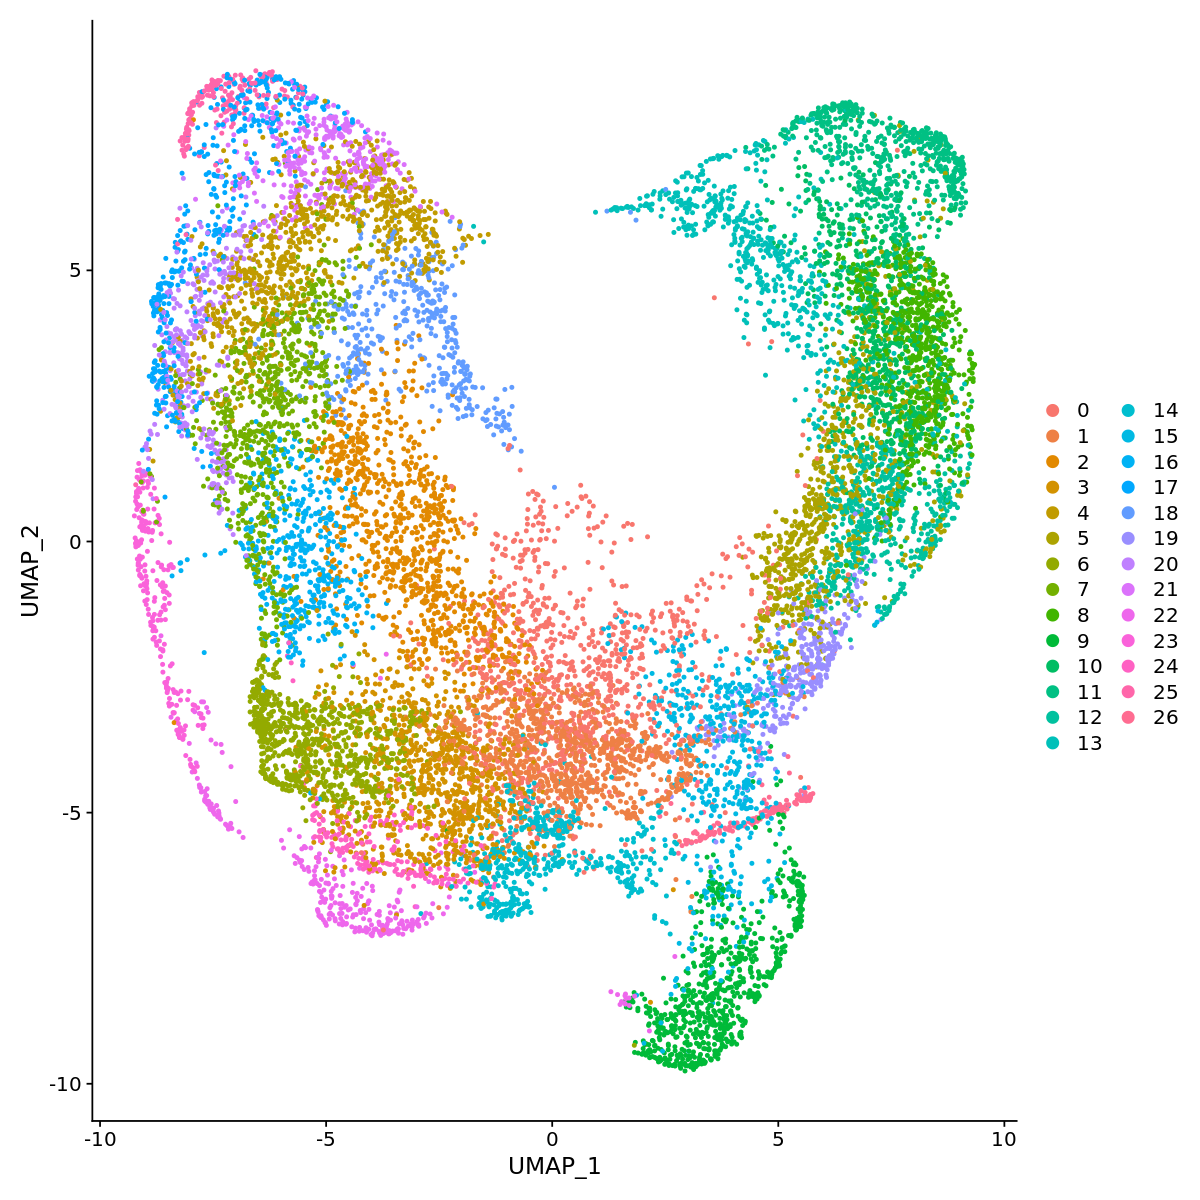

In [95]:
plot = DimPlot(seu_intd_wt, reduction = "umap", label = FALSE, pt.size = .75)
print(plot)
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/WT_UMAP.png", plot=plot, width=10, height=10)

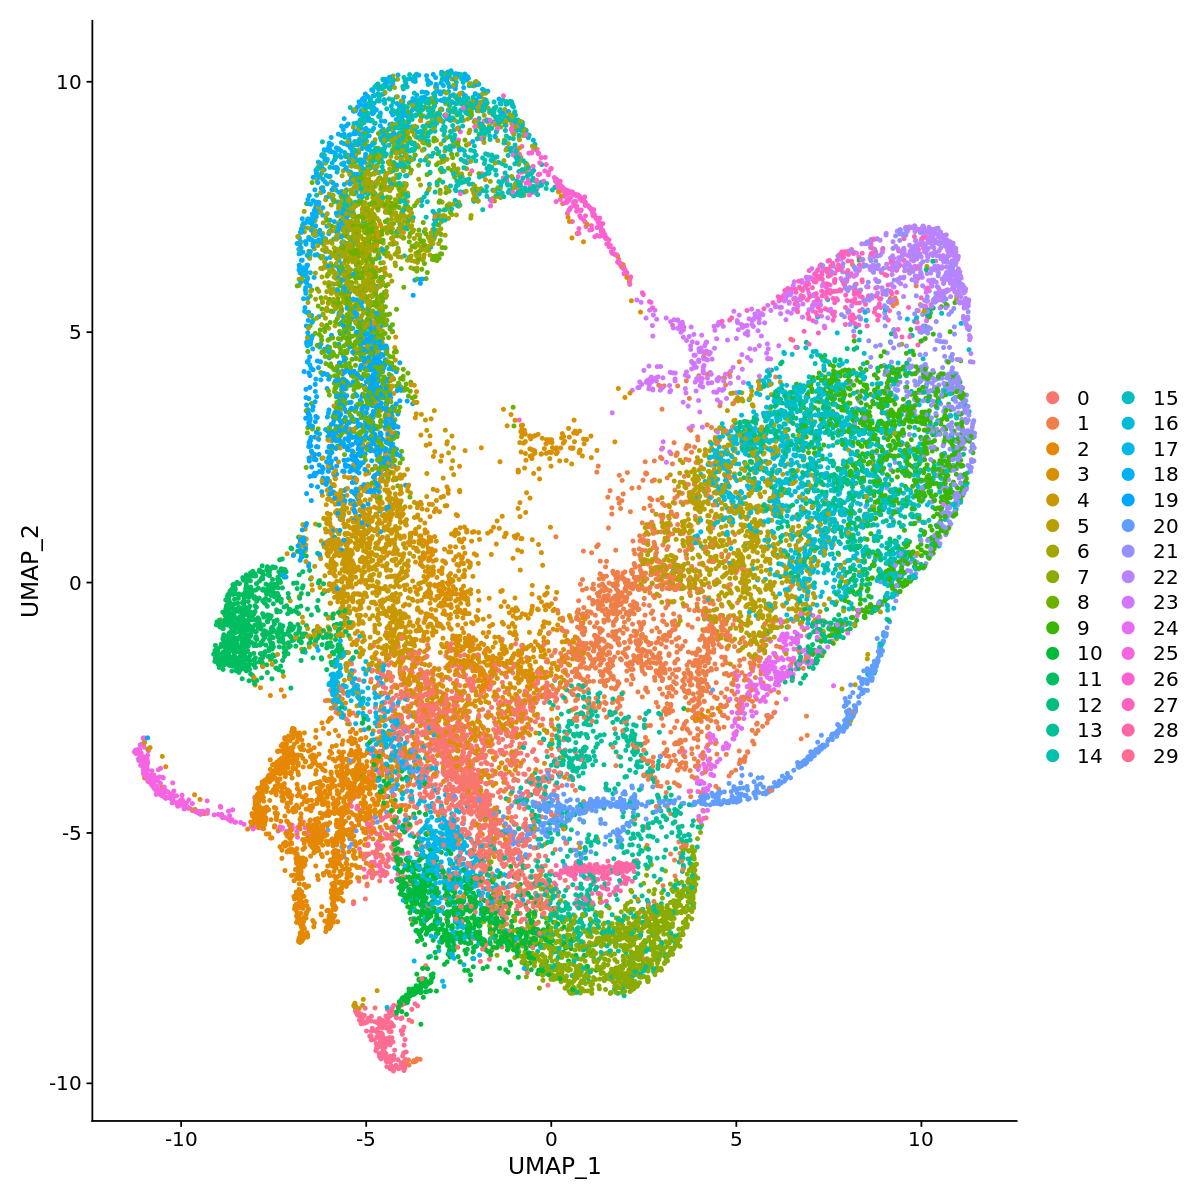

In [96]:
Idents(seu_intd_mut) = seu_intd_mut$seurat_clusters
options(repr.plot.width= 10, repr.plot.height=10)
plot = DimPlot(seu_intd_mut, reduction = "umap", label = FALSE, pt.size = .75)
print(plot)

In [97]:
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/mutant_UMAP.png", plot=plot, width=10, height=10)

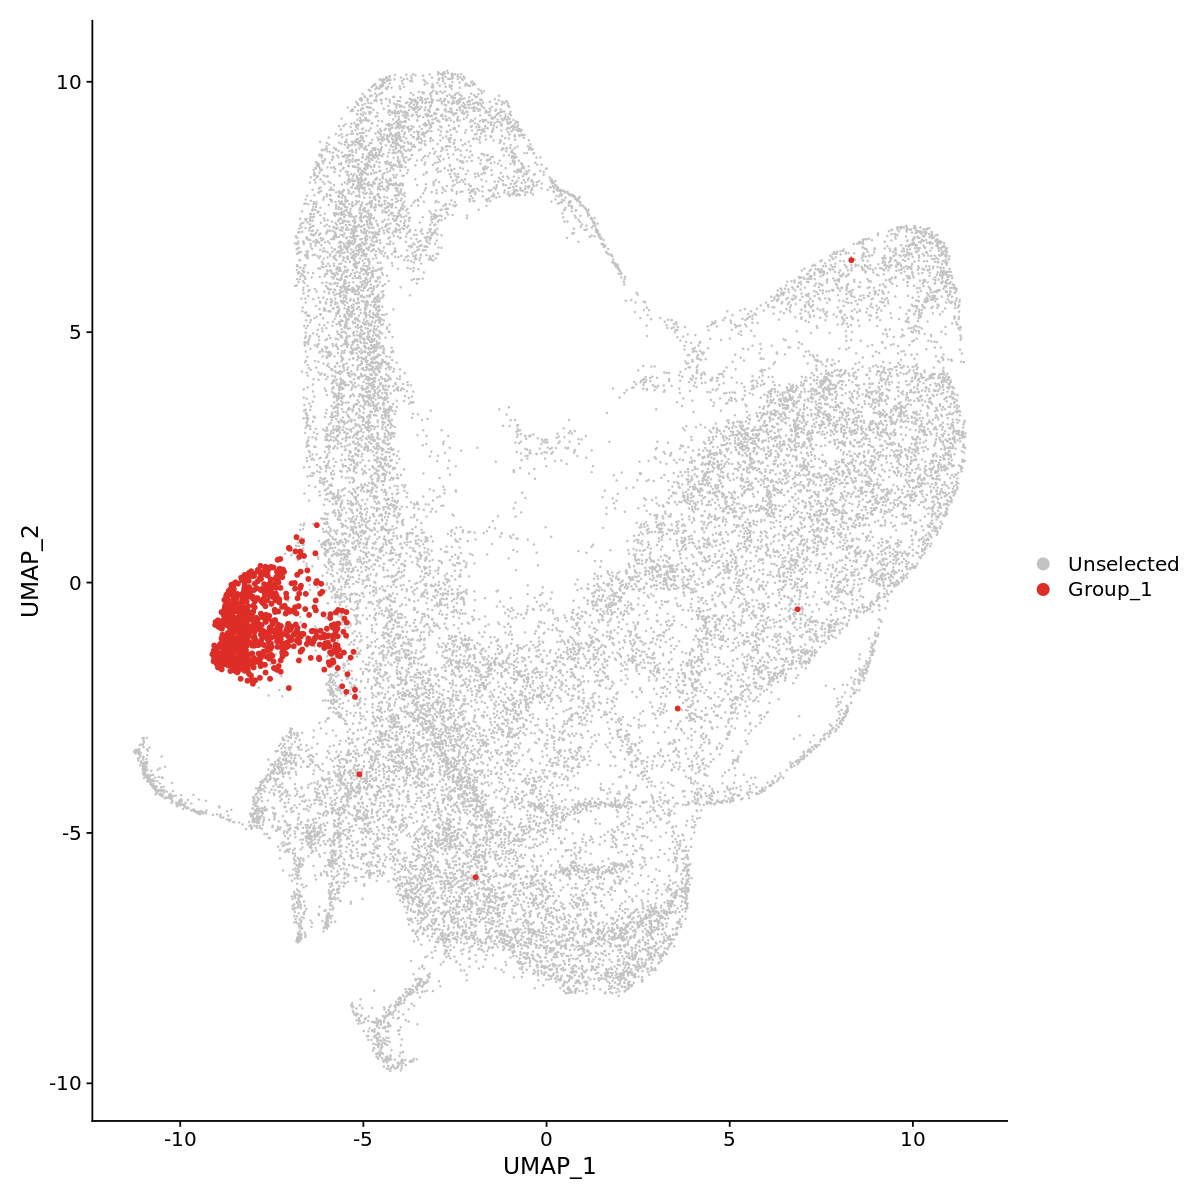

In [77]:
Idents(seu_intd_mut) = seu_intd_mut$seurat_clusters
options(repr.plot.width= 10, repr.plot.height=10)
AZ_cells = WhichCells(seu_intd_mut, ident = "11")
plot = DimPlot(seu_intd_mut, reduction = "umap", cells.highlight = AZ_cells, label = FALSE)
print(plot)

In [78]:
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/mutant_UMAP_cluster_11.png", plot=plot, width=10, height=10)

In [ ]:
saveRDS(seu_intd_mut, file = "../data/seurat_objects/seurat_mut_intd_2_17_22.rds")

In [3]:
seu_intd_wt = readRDS(file = "../data/seurat_objects/seurat_WT_intd_2_17_21.rds")
seu_intd_mut = readRDS(file = "../data/seurat_objects/seurat_mut_intd_2_17_22.rds")

In [6]:
DefaultAssay(seu_intd_wt) = "integrated"

In [ ]:
#try cell type classification (simple) with seurat. From:
#https://satijalab.org/seurat/archive/v3.0/integration.html
AZ.anchors <- FindTransferAnchors(reference = seu_intd_wt, query = seu_intd_mut, dims = 1:30)

In [12]:
AZ.anchors

An AnchorSet object containing 16067 anchors between 1 Seurat objects 
 This can be used as input to IntegrateData or TransferData.

In [8]:
predictions <- TransferData(anchorset = AZ.anchors, refdata = seu_intd_wt$seurat_clusters, dims = 1:30)
seu_intd_mut <- AddMetaData(seu_intd_mut, metadata = predictions)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [9]:
saveRDS(seu_intd_mut, file = "../data/seurat_objects/seurat_mut_intd_label_transferred_3_10_22.rds")

In [61]:
#read in data for cluster assignment
#protoplast
proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 4,]$genes)

#kwak data
kwak_ptpms=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms) = kwak_ptpms$X
kwak_ptpms[,c(1,2,3)] =NULL
colnames(kwak_ptpms) = "counts"

#HAE_YFP_and_KE sorted
YFP_KE = read.csv("../data/counts/sorted_bulk_edger_1_20_21.csv")
YFP_av = data.frame(YFP_KE[,8])
rownames(YFP_av) = YFP_KE[,1]               

#trava
trava_ptms=read.csv("../data/bulk_data/trava_ptpms.csv")

carpels = data.frame(trava_ptms$carpels)
rownames(carpels) = trava_ptms$X
colnames(carpels) = "counts"

fils = data.frame(trava_ptms$filaments)
rownames(fils) = trava_ptms$X
colnames(fils) = "counts"

seps = data.frame(trava_ptms$sepals)
rownames(seps) = trava_ptms$X
colnames(seps) = "counts"

pets = data.frame(trava_ptms$petals)
rownames(pets) = trava_ptms$X
colnames(pets) = "counts"

In [64]:
#get pseudobulk for each cluster to compare with kwak data
DefaultAssay(seu_intd_mut) <- "RNA"
pbs = list()
count = 1
for (l in levels(seu_intd_mut@meta.data$seurat_clusters)) {
    pbs[[count]] = rowSums(as.matrix(GetAssayData(seu_intd_mut, slot = "counts")[, WhichCells(seu_intd_mut, ident = l)])) 
    count = count + 1
}

In [65]:
#convert pseudobulk to TPM
count = 1
for (c in pbs) {
    pbs[[count]] = data.frame(pbs[[count]])/sum(data.frame(pbs[[count]]))*1000000
    rns = rownames(pbs[[count]])
    pbs[[count]] = pbs[[count]][order(rns),, drop = FALSE]
    count = count + 1
}

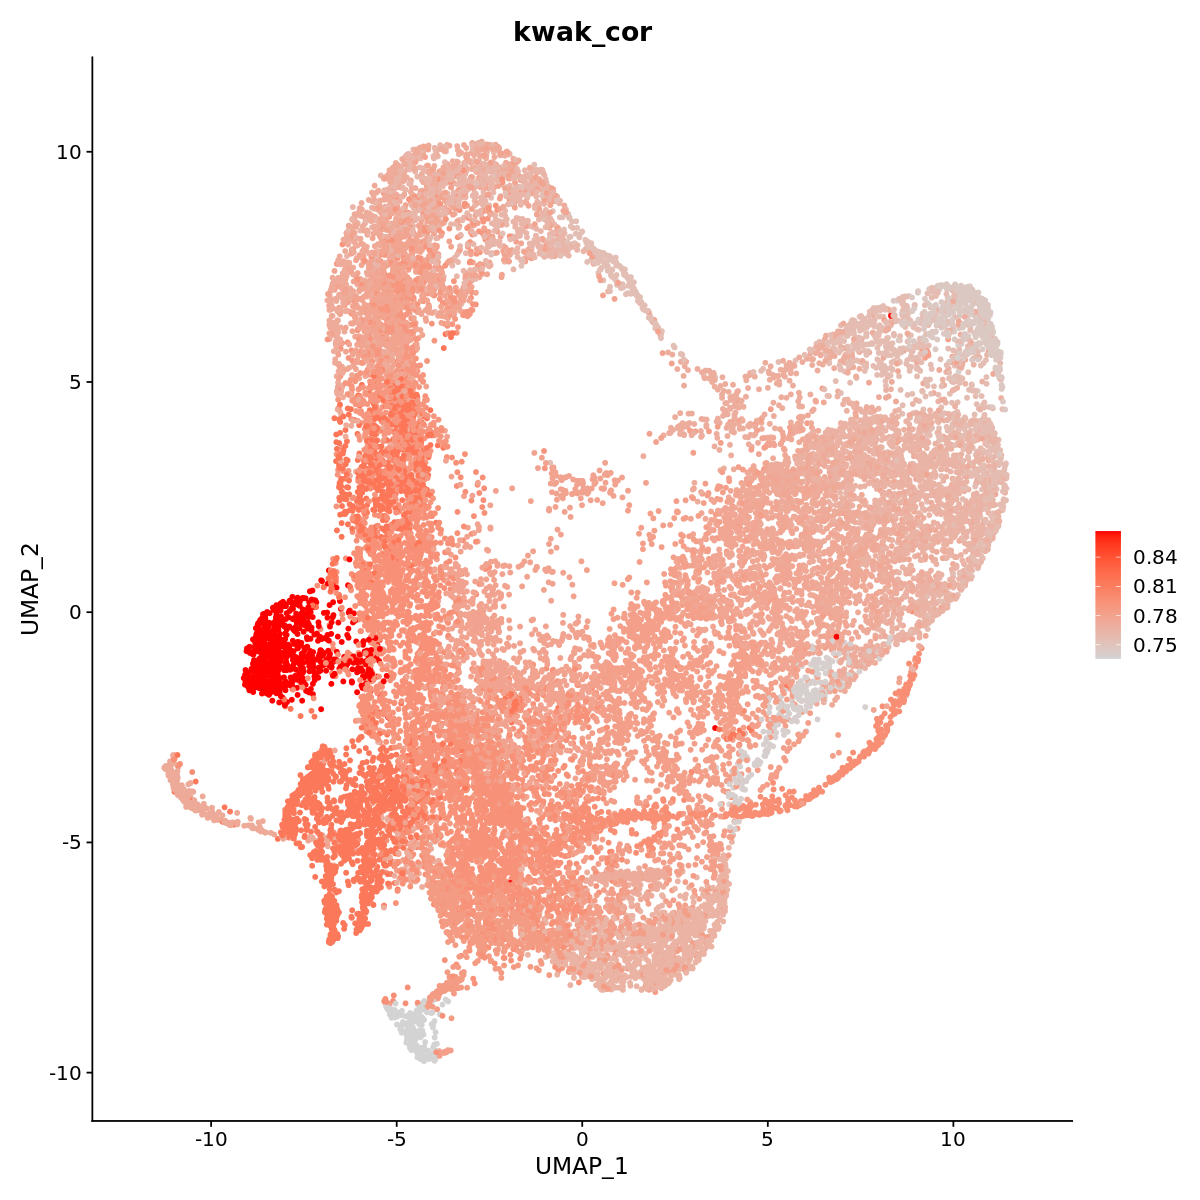

In [82]:
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_mut@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_mut@meta.data$seurat_clusters)))){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_mut@meta.data$seurat_clusters)))){
    seu_intd_mut@meta.data$kwak_cor[seu_intd_mut@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_mut,  features = "kwak_cor", pt.size = 1, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/mutant_kwak_cor_UMAP.png", plot=plot, width=10, height=10)

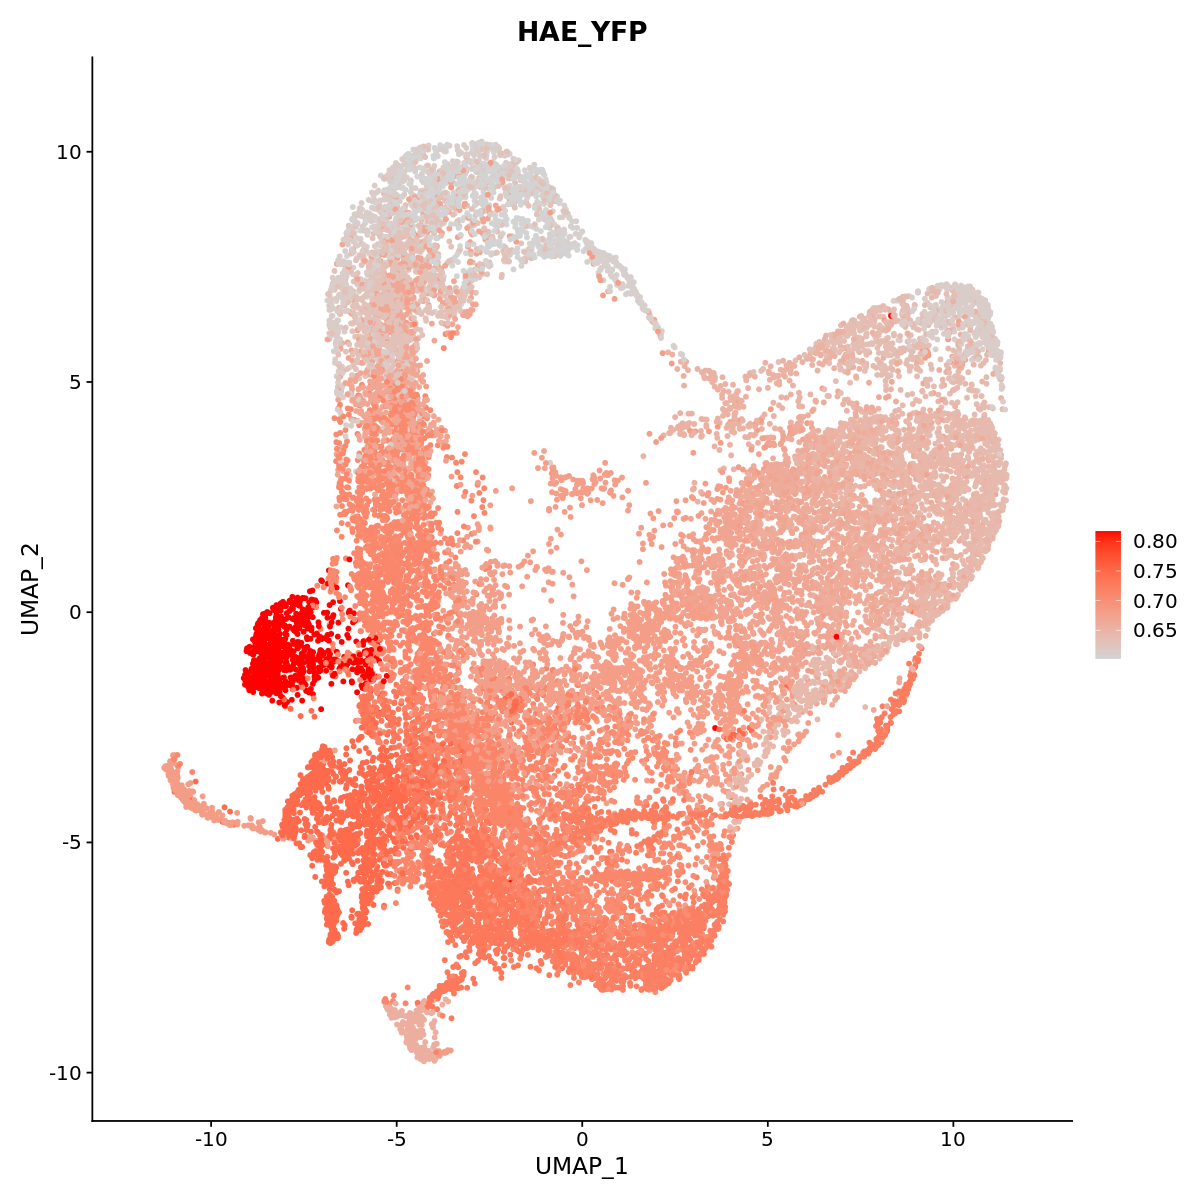

In [83]:
#set dataset
dataset = YFP_av
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_mut@meta.data$HAE_YFP = NULL

for (cluster in c(1:length(levels(seu_intd_mut@meta.data$seurat_clusters)))){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_mut@meta.data$seurat_clusters)))){
    seu_intd_mut@meta.data$HAE_YFP[seu_intd_mut@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_mut,  features = "HAE_YFP", pt.size = 1, cols = c("light gray", "red"))
#png("HAE_YFP_cor_wt_2_1_22.png")
print(plot)   
#dev.off() 
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/mutant_YFP_cor_UMAP.png", plot=plot, width=10, height=10)

In [ ]:
genes = c("AT4G28490","AT5G65710","AT3G07970","AT2G41850","AT1G68320","AT3G59850","AT5G03820","AT1G68765","AT3G44540","AT3G44550","AT3G44560")
genes

DefaultAssay(seu_intd_mut) <- "SCT"
options(repr.plot.width=8, repr.plot.height=8)

for (g in genes) {
    plot = FeaturePlot(seu_intd_mut, features = g,  pt.size = 4, min = .75, order = TRUE)#, split.by = "experiment")# + scale_colour_gradient(low = "gray94", high = "red", space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour")
    print(plot)   
    #ggsave(file=paste0("/home/robotmessenger810/sc_analysis/data/for_figures/gene_plots/figure_2_pngs/",g, ".png"), plot=plot, width=10, height=10)
}



In [3]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))
# loop
#    for (i in 1:length(seu.list)) {
#         seu.list[[i]]@assays$spliced_RNA <- NULL
#         seu.list[[i]]@assays$spliced_SCT <- NULL
#         seu.list[[i]]@assays$unspliced_RNA <- NULL
#         seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
    rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
#    }
}


specificity_resolution <- function(seu_obj1, gois, resolutions) { #..., filename, nfeatures){
    total_sum_df = data.frame(matrix(ncol = 6)) #cols = resolution, cluster, goi count, total count, num cells, cross-entropy (?)
    count = 0

    for (r in resolutions) {
        set.seed(42)
        seu_obj = seu_obj1
        DefaultAssay(seu_obj) <- "integrated"
        options(repr.plot.width=12, repr.plot.height=12)
        seu_obj <- RunPCA(seu_obj, npcs = 100, verbose = FALSE, approx = FALSE)
        seu_obj <- FindNeighbors(seu_obj, dims = 1:20, verbose = FALSE)
        seu_obj <- FindClusters(seu_obj, resolution = r, algorithm = 3, verbose = FALSE)
        seu_obj <- RunUMAP(seu_obj, reduction = "pca", dims = 1:20, verbose = FALSE)

        clusters = unique(Idents(seu_obj))
        seu_obj@active.assay = "SCT" #"SCT"
        count = 0
        partial_sum_df = data.frame(matrix(ncol = 6))
        for (c in clusters) {
            count = count + 1
            AZ_cells = (as.matrix(GetAssayData(subset(seu_obj, slot = "counts")[, WhichCells(seu_obj, ident = c)])))
            goi_sum = sum(AZ_cells[gois,])
            total_sum = sum(AZ_cells)

            partial_sum_df[count,1] = r
            partial_sum_df[count,2] = c
            partial_sum_df[count,3] = goi_sum
            partial_sum_df[count,4] = total_sum
            partial_sum_df[count,5] = dim(AZ_cells)[2]

        }

        for (c in clusters) {
            others = partial_sum_df[partial_sum_df[,2] != c,]
            cluster = partial_sum_df[partial_sum_df[,2] == c,]
            #partial_sum_df[which(partial_sum_df[,2]==c),6] = (sum(cluster[,3]!=0)/dim(cluster)[1])/(sum(others[,3]!=0)/dim(others[1]))
            partial_sum_df[which(partial_sum_df[,2]==c),6] = (sum(cluster[,3])/sum(cluster[,4]))/(sum(others[,3])/sum(others[,4]))
        }
        total_sum_df = rbind(total_sum_df, partial_sum_df)
    }
    return(total_sum_df[-1,])
}